In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


# Standardized Precipitation Index

Pulled from https://www.ncei.noaa.gov/pub/data/nidis/indices/nclimgrid-monthly/spei-pearson/

- Uses precipitation only; can characterize drought or abnormal wetness at different time scales which correspond with the time availability of different water resources (e.g. soil moisture, snowpack, groundwater, river discharge and reservoir storage)

- More comparable across regions with different climates than the Palmer Severity Drought Index (PDSI)

- Less complex to calculate than the PDSI

- As a measure of water supply only, the SPI does not account for evapotranspiration, and this limits its ability to capture the effect of increased temperatures (associated with climate change) on moisture demand and availability

- Sensitive to the quantity and reliability of the data used to fit the distribution; 30-50 years recommended

- Does not consider the intensity of precipitation and its potential impacts on runoff, streamflow, and water availability within the system of interest
- Extremes are -2 to +2


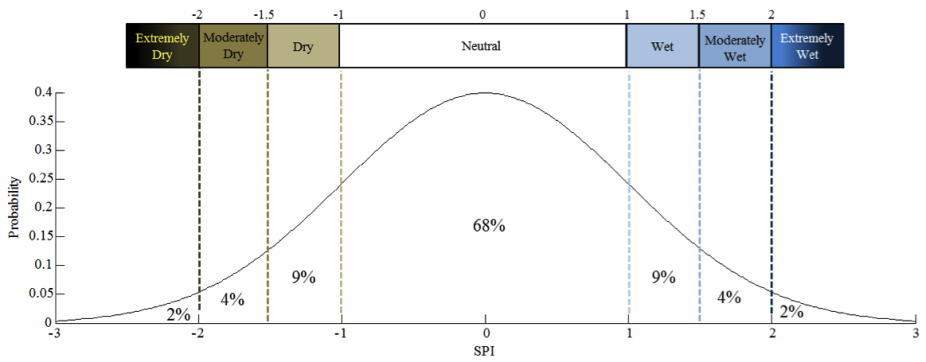

In [2]:
# open ucrb boundary
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_bounds = ucrb_basin_boundary.total_bounds
# also clip to hcdn basins
ucrb_hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json').set_geometry('geometry').set_crs(32613, allow_override=True)
ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs('4326')
# open ucrb boundary
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# also clip to hcdn basins
ucrb_hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json').set_geometry('geometry').set_crs(32613, allow_override=True)
ucrb_hcdn_basins = ucrb_hcdn_basins.to_crs('4326')


### Process 12-month and 60-month SPI data

In [4]:
# 12-month SPI data
# open standardized precipitation index
spi12 = rxr.open_rasterio('/storage/dlhogan/sos/data/nclimgrid-spi-pearson-12.nc', chunks={'x':10,'y':10, 'time':10}, crs='EPSG:4326')
# filter data
spi12_ma = spi12.where((spi12>-10) & (spi12<10)).rio.write_crs(4326)
# cut off to ucrb and hcdn locations
ucrb_spi12 = spi12_ma.rio.clip(ucrb_basin_boundary.geometry)
hcdn_spi12 = spi12_ma.rio.clip(ucrb_hcdn_basins.geometry)

# This works but does not finish running for some reason...
# hcdn_spi12.to_netcdf('../data/precipdata/SPI/ucrb_hcdn_spi12.nc', compute=True)

In [5]:
# 12-month SPI data
# open standardized precipitation index
spi60 = rxr.open_rasterio('/storage/dlhogan/sos/data/nclimgrid-spi-pearson-60.nc', chunks={'x':10,'y':10, 'time':10}, crs='EPSG:4326')
# filter data
spi60_ma = spi60.where((spi60>-10) & (spi60<10)).rio.write_crs(4326)
# cut off to ucrb and hcdn locations
ucrb_spi60 = spi60_ma.rio.clip(ucrb_basin_boundary.geometry)
hcdn_spi60 = spi60_ma.rio.clip(ucrb_hcdn_basins.geometry)

# This works but does not finish running for some reason...
# ucrb_spi60.to_netcdf('../data/precipdata/SPI/ucrb_spi60.nc', compute=True)
# hcdn_spi60.to_netcdf('../data/precipdata/SPI/ucrb_hcdn_spi60.nc', compute=True)

Text(0.5, 1.0, '5 Year Rolling Average Standardized\nPrecipitation Index over the UCRB')

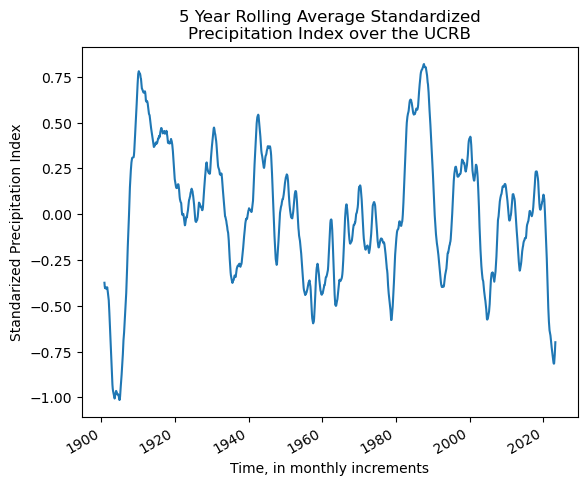

In [6]:
fig, ax = plt.subplots()
xr.open_dataset('../data/precipdata/SPI/ucrb_spi12.nc').mean(dim=['x','y'])['spi_12'].rolling(time=60).mean().plot(ax=ax)
ax.set_ylabel('Standarized Precipitation Index')
ax.set_title('5 Year Rolling Average Standardized\nPrecipitation Index over the UCRB')

Make an example plot of the UCRB SPI and HCDN over the same period

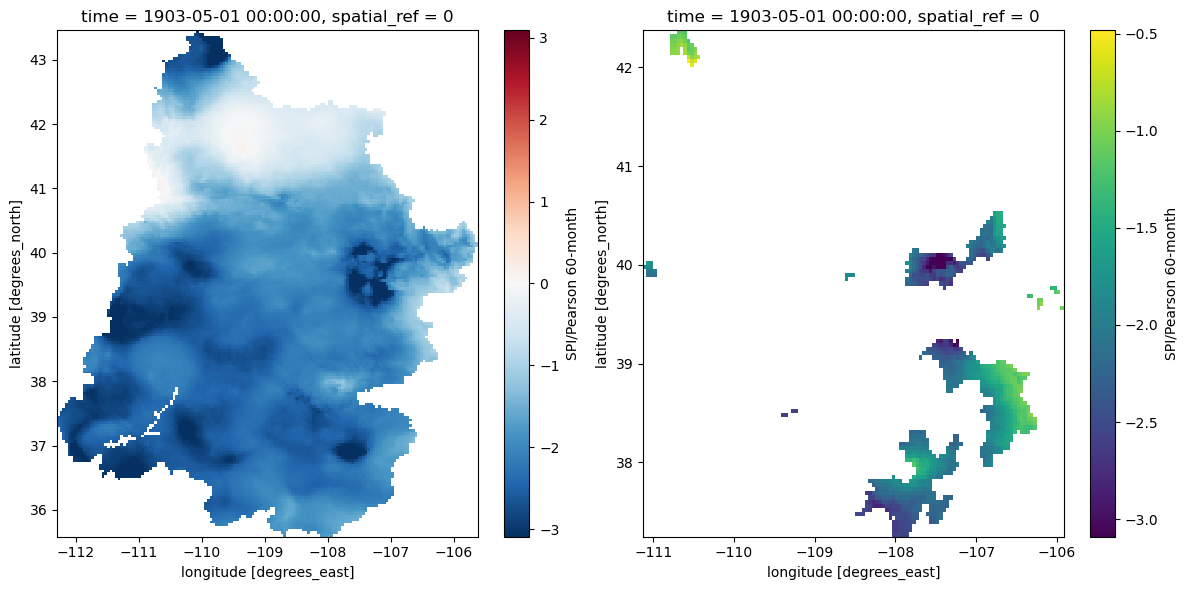

In [7]:
fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(12,6))
ucrb_spi60.where((ucrb_spi60>-10) & (ucrb_spi60<10)).isel(time=100).plot(ax=ax[0])
hcdn_spi60.where((hcdn_spi60>-10) & (hcdn_spi60<10)).isel(time=100).plot(ax=ax[1])

### Make a timeseries plot of SPI for the UCRB as a whole

In [8]:
# Create product for all HCDN basins for 12 month 
spi12_ucrb_hcdn = rxr.open_rasterio('../data/precipdata/SPI/ucrb_hcdn_spi12.nc')
spi12_ucrb_hcdn_list = []                                  
for basin in ucrb_hcdn_basins.gage:
    try:
        example_basin_spi = spi12_ucrb_hcdn.rio.clip(ucrb_hcdn_basins[ucrb_hcdn_basins.gage==basin].geometry)
        example_basin_spi_ma = example_basin_spi.where(example_basin_spi>-10).mean(dim=['x','y'])
        example_basin_spi_ma.name = basin
        spi12_ucrb_hcdn_list.append(example_basin_spi_ma)
    except:
        pass

In [9]:
spi12_ucrb_hcdn_df = xr.merge(spi12_ucrb_hcdn_list).to_dataframe().drop(columns=['spatial_ref'])
spi12_ucrb_hcdn_df.index = spi12_ucrb_hcdn_df.index.to_datetimeindex()

In [10]:
# UCRB as a whole average 5 year SPI, not a clear signal
spi12_ucrb_rolling = xr.open_dataset('../data/precipdata/SPI/ucrb_spi12.nc').mean(dim=['x','y'])['spi_12'].to_dataframe()
spi12_ucrb_rolling = spi12_ucrb_rolling.rename(columns={'spi_12':'UCRB Mean - 12 month'})

In [11]:
# Create product for all HCDN basins for 60 month
spi60_ucrb_hcdn = rxr.open_rasterio('../data/precipdata/SPI/ucrb_hcdn_spi60.nc')
spi60_ucrb_hcdn_list = []                                  
for basin in ucrb_hcdn_basins.gage:
    try:
        example_basin_spi = spi60_ucrb_hcdn.rio.clip(ucrb_hcdn_basins[ucrb_hcdn_basins.gage==basin].geometry)
        example_basin_spi_ma = example_basin_spi.where(example_basin_spi>-10).mean(dim=['x','y'])
        example_basin_spi_ma.name = basin
        spi60_ucrb_hcdn_list.append(example_basin_spi_ma)
    except:
        pass

In [12]:
spi60_ucrb_hcdn_df = xr.merge(spi60_ucrb_hcdn_list).to_dataframe().drop(columns=['spatial_ref'])
spi60_ucrb_hcdn_df.index = spi60_ucrb_hcdn_df.index.to_datetimeindex()

In [13]:
# UCRB as a whole average 5 year SPI, not a clear signal
spi60_ucrb_rolling = xr.open_dataset('../data/precipdata/SPI/ucrb_spi60.nc').mean(dim=['x','y'])['spi_60'].to_dataframe()
spi60_ucrb_rolling = spi60_ucrb_rolling.rename(columns={'spi_60':'UCRB Mean - 60 Month'})

### Naturalized Streamflow

In [14]:
# Let's add in the Naturalized Streamflow to see how that compares
naturalized_flow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None)
naturalized_flow['date'] = [str(val)+'-10-01' for val in naturalized_flow[0]]
naturalized_flow.date = pd.to_datetime(naturalized_flow.date)
naturalized_flow = naturalized_flow.set_index('date')
naturalized_flow = naturalized_flow.rename(columns={0:'year',1:'flow'})

norm_naturalized_flow = (naturalized_flow - naturalized_flow.mean())/naturalized_flow.std()
norm_naturalized_flow = norm_naturalized_flow.drop(columns=['year'])

empty_dates = pd.date_range(start='1895-10-01',end='1905-10-1',freq='AS-Oct')
empty_values = [np.nan for d in empty_dates]
empty_series = pd.DataFrame(empty_values,index=empty_dates, columns=['flow'])

norm_naturalized_flow_1895 = pd.concat([empty_series,norm_naturalized_flow])


### Plot these against each other

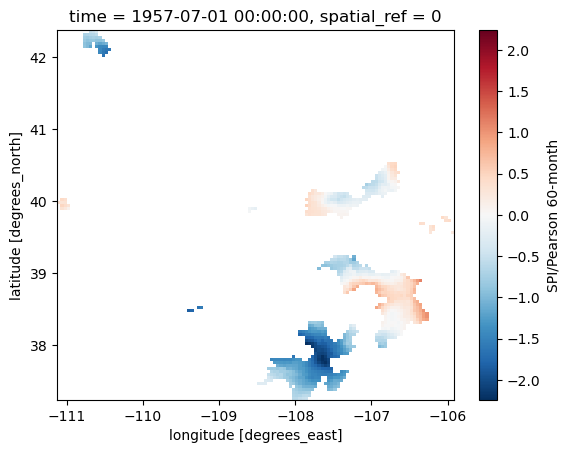

In [15]:
spi60_ucrb_hcdn.where((spi60_ucrb_hcdn<3.1) & (spi60_ucrb_hcdn>-3.1)).isel(time=750).plot()

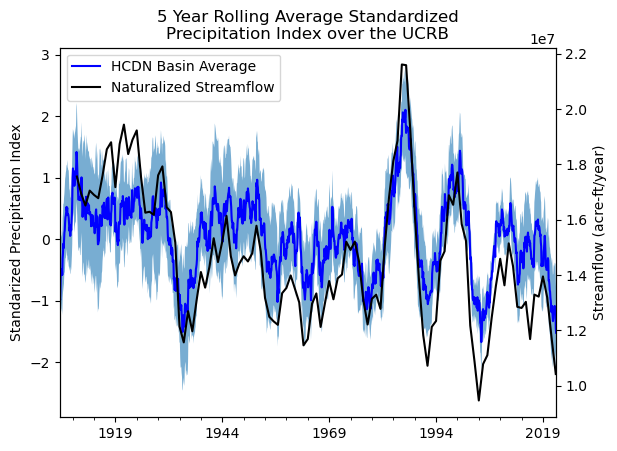

In [16]:
fig, ax = plt.subplots()

# SPI for the entire UCRB
# spi12_ucrb_rolling.plot(ax=ax, color = 'orange', label='UCRB average - 12 mo')
# spi60_ucrb_rolling.plot(ax=ax, color = 'blue', label='UCRB average - 60 mo')
# HCDN mean and standard deviation
spi60_ucrb_hcdn_df.mean(axis=1).plot(ax=ax, color='blue', label='HCDN Basin Average')
ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1)-spi60_ucrb_hcdn_df.std(axis=1),
                spi60_ucrb_hcdn_df.mean(axis=1)+spi60_ucrb_hcdn_df.std(axis=1),
                alpha=0.60
                )

# Natualized Streamflow
ax2 = ax.twinx()
naturalized_flow['flow'].rolling(5).mean().plot(ax=ax2, color='k', label='Naturalized Streamflow')
# add to legend
ax.plot([],[], color='k', label='Naturalized Streamflow')
ax2.set_ylabel('Streamflow (acre-ft/year)')

ax.set_ylabel('Standarized Precipitation Index')
ax.set_title('5 Year Rolling Average Standardized\nPrecipitation Index over the UCRB')
ax.legend(loc='upper left')

# Palmer Drought Severity Index

- Effective in determining long-term drought, especially over low and middle latitudes

- By using surface air temperature and a physical water balance model, the PDSI takes into account the basic effect of global warming through potential evapotranspiration

- Takes precedent (prior month) conditions into account

- Not as comparable across regions as the Standardized Precipitation Index (SPI), but this can be alleviated by using the self-calibrating PDSI

- Lacks multi-timescale features of indices like the SPI, making it difficult to correlate with specific water resources like runoff, snowpack, resevoir storage, etc.

- Does not account for snow or ice (delayed runoff); assumes precipitation is immediately available
- Extremes are -4 to +4 (but can range between -10 and +10)

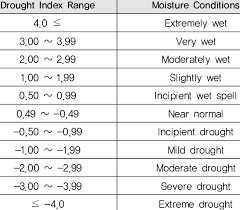

### Monthly Hi-res PDSI
PDSI from 1980-2022

In [17]:
pdsi = xr.open_dataset('../data/precipdata/agg_met_pdsi_1979_CurrentYear_CONUS.nc')
pdsi_monthly = pdsi.resample(day='1M').mean().rolling(day=12).mean()


<AxesSubplot: title={'center': 'day = 2021-04-30'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

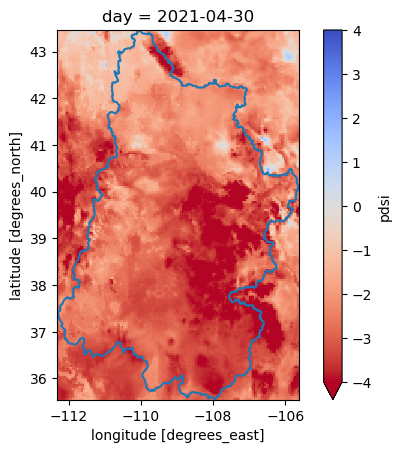

In [30]:
fig, ax = plt.subplots()
pdsi_monthly.sel(day = '2021-04-30')['daily_mean_palmer_drought_severity_index'].plot(ax=ax, vmin=-4, vmax=4, cmap='coolwarm_r')
ucrb_basin_boundary.boundary.plot(ax=ax)

In [18]:
from pathlib import Path
import pandas as pd
import numpy as np

path = r'../data/precipdata/PDSI/'  # or unix / linux / mac path

# Get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

pdsi_dfs = list()
for f in files:
    data = pd.read_csv(f, skiprows=4, header=None)

    data['date'] = [str(val)+'01' for val in data[0]]
    data.date = pd.to_datetime(data.date)
    data = data.rename(columns={0:'date_raw',1:'value',2:'anomaly'})
    # .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f.stem
    pdsi_dfs.append(data)

pdsi_df = pd.concat(pdsi_dfs, ignore_index=True)
pdsi_df = pdsi_df.set_index('date')
pdsi_df = pdsi_df.sort_index()
pdsi_df.tail()

,date_raw,value,anomaly,file
date,,,,
2022-12-01,202212,0.50,0.34,pdsi_ucrb_12
2023-01-01,202301,1.42,1.14,pdsi_ucrb_01
2023-02-01,202302,1.81,1.49,pdsi_ucrb_02
2023-03-01,202303,2.93,2.69,pdsi_ucrb_03
2023-04-01,202304,2.53,2.36,pdsi_ucrb_04


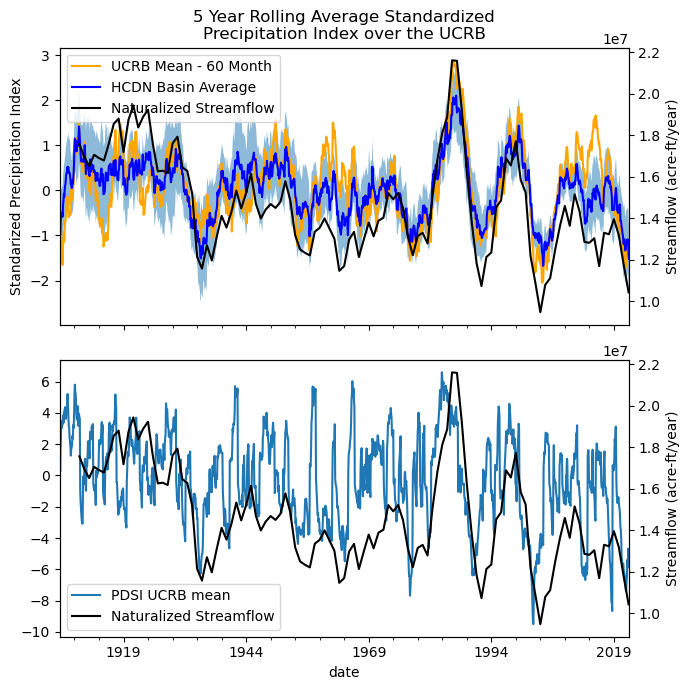

In [21]:
fig, axs = plt.subplots(2, sharex=True, tight_layout=True, figsize=(7,7))

ax = axs[0]
# SPI for the entire UCRB
spi60_ucrb_rolling.plot(ax=ax, color = 'orange', label='UCRB average')
# HCDN mean and standard deviation
spi60_ucrb_hcdn_df.mean(axis=1).plot(ax=ax, color='blue', label='HCDN Basin Average')
ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1)-spi60_ucrb_hcdn_df.std(axis=1),
                spi60_ucrb_hcdn_df.mean(axis=1)+spi60_ucrb_hcdn_df.std(axis=1),
                alpha=0.5)

# Natualized Streamflow
ax2 = ax.twinx()
naturalized_flow['flow'].rolling(5).mean().plot(ax=ax2, color='k', label='Naturalized Streamflow')
# add to legend
ax.plot([],[], color='k', label='Naturalized Streamflow')
ax2.set_ylabel('Streamflow (acre-ft/year)')

ax.set_ylabel('Standarized Precipitation Index')
ax.set_title('5 Year Rolling Average Standardized\nPrecipitation Index over the UCRB')
ax.legend()

ax = axs[1]
pdsi_df['anomaly'].plot(ax=ax, label='PDSI UCRB mean')

# Natualized Streamflow
ax2 = ax.twinx()
naturalized_flow['flow'].rolling(5).mean().plot(ax=ax2, color='k', label='Naturalized Streamflow')
# add to legend
ax.plot([],[], color='k', label='Naturalized Streamflow')
ax2.set_ylabel('Streamflow (acre-ft/year)')
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


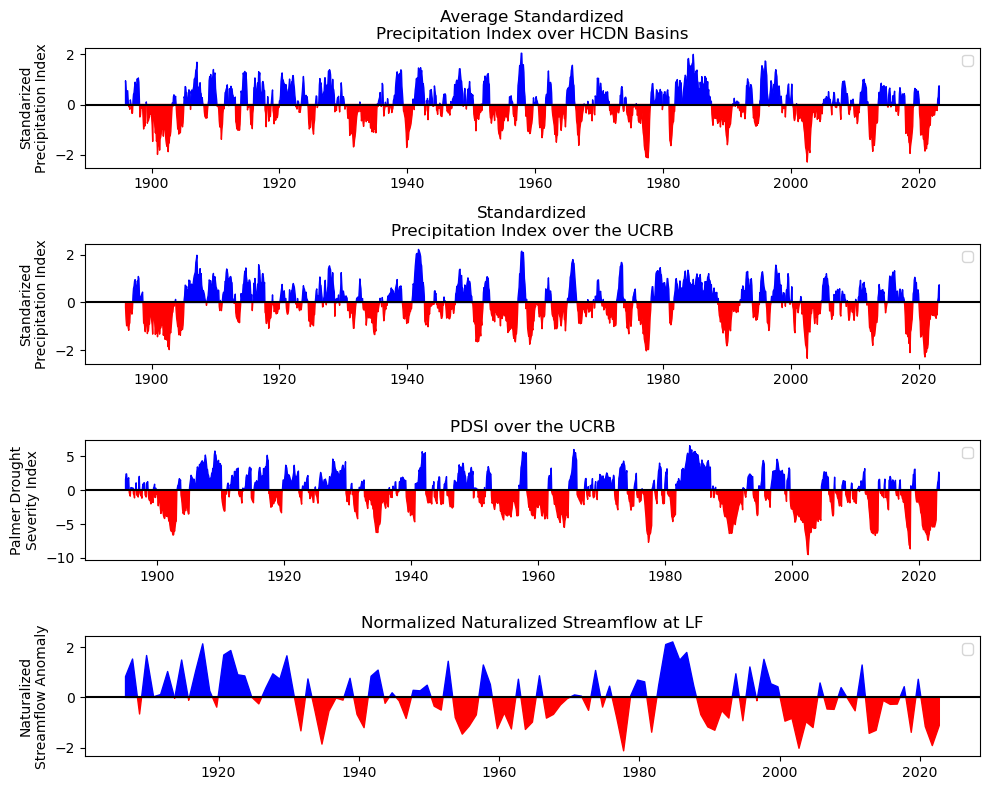

In [24]:
fig, axs = plt.subplots(nrows=4, figsize=(10,8),tight_layout=True)
# spi_ucrb_rolling.plot(ax=ax, color = 'orange', label='UCRB average')
# spi12_ucrb_hcdn_df.mean(axis=1).plot(ax=ax, color='blue', label='HCDN Basin Average')
ax = axs[0]


ax.fill_between(spi12_ucrb_hcdn_df.index, 
                spi12_ucrb_hcdn_df.mean(axis=1),
                where=spi12_ucrb_hcdn_df.mean(axis=1)>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi12_ucrb_hcdn_df.index, 
                spi12_ucrb_hcdn_df.mean(axis=1),
                where=spi12_ucrb_hcdn_df.mean(axis=1)<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')

ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Average Standardized\nPrecipitation Index over HCDN Basins')
ax.legend()

# UCRB Basin Plot
ax = axs[1]

ax.fill_between(spi12_ucrb_rolling.index, 
                spi12_ucrb_rolling['UCRB Mean - 12 month'],
                where=spi12_ucrb_rolling['UCRB Mean - 12 month']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi12_ucrb_rolling.index, 
                spi12_ucrb_rolling['UCRB Mean - 12 month'],
                where=spi12_ucrb_rolling['UCRB Mean - 12 month']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Standardized\nPrecipitation Index over the UCRB')
ax.legend()

# PDSI Plot over UCRB
ax = axs[2]
ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                alpha=0.5)

ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi12_ucrb_rolling.index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Palmer Drought\nSeverity Index')
ax.set_title('PDSI over the UCRB')
ax.legend()

# Plot Naturalized Streamflow
ax = axs[3]

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']>=norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='blue')

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']<norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_title('Normalized Naturalized Streamflow at LF')
ax.set_ylabel('Naturalized\nStreamflow Anomaly')
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


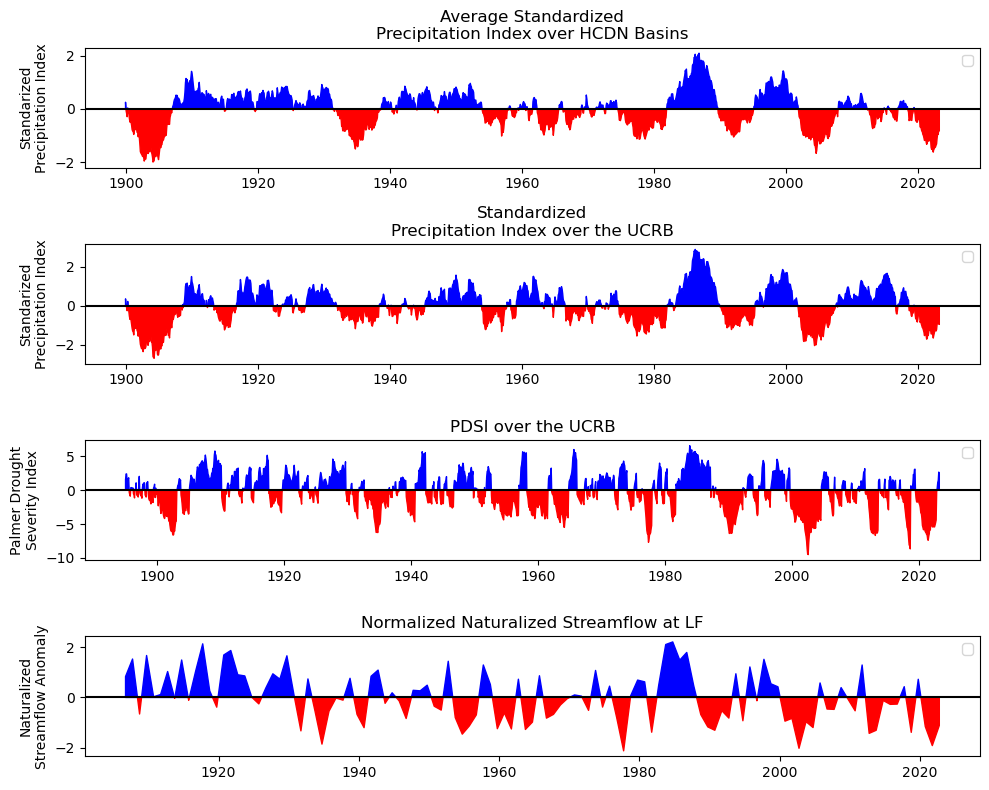

In [28]:
fig, axs = plt.subplots(nrows=4, figsize=(10,8),tight_layout=True)
# spi_ucrb_rolling.plot(ax=ax, color = 'orange', label='UCRB average')
# spi60_ucrb_hcdn_df.mean(axis=1).plot(ax=ax, color='blue', label='HCDN Basin Average')
ax = axs[0]


ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1),
                where=spi60_ucrb_hcdn_df.mean(axis=1)>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1),
                where=spi60_ucrb_hcdn_df.mean(axis=1)<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')

ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Average Standardized\nPrecipitation Index over HCDN Basins')
ax.legend()

# UCRB Basin Plot
ax = axs[1]

ax.fill_between(spi60_ucrb_rolling.index, 
                spi60_ucrb_rolling['UCRB Mean - 60 Month'],
                where=spi60_ucrb_rolling['UCRB Mean - 60 Month']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi60_ucrb_rolling.index, 
                spi60_ucrb_rolling['UCRB Mean - 60 Month'],
                where=spi60_ucrb_rolling['UCRB Mean - 60 Month']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Standardized\nPrecipitation Index over the UCRB')
ax.legend()

# PDSI Plot over UCRB
ax = axs[2]
ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                alpha=0.5)

ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi12_ucrb_rolling.index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Palmer Drought\nSeverity Index')
ax.set_title('PDSI over the UCRB')
ax.legend()

# Plot Naturalized Streamflow
ax = axs[3]

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']>=norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='blue')

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']<norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_title('Normalized Naturalized Streamflow at LF')
ax.set_ylabel('Naturalized\nStreamflow Anomaly')
ax.legend()

# Standardized Precipitation Evapotranspiration Index

- Combines multi-timescales aspects of the Standardized Precipitation Index (SPI) with information about evapotranspiration, making it more useful for climate change studies

- Statistically based index that requires only climatological information without assumptions about the characteristics of the underlying system

- More data requirements than the precipitation SPI

- Sensitive to the method to calculate potential evapotranspiration (PET)

- As with other drought indices, a long base period (30-50+ years) that samples the natural variability should be used

In [29]:
# 12-month SPI data
# open standardized precipitation index
spei12 = rxr.open_rasterio('/storage/dlhogan/sos/data/nclimgrid-spei-pearson-12.nc', chunks={'x':10,'y':10, 'time':10}, crs='EPSG:4326')
# filter data
spei12_ma = spei12.where((spei12>-10) & (spei12<10)).rio.write_crs(4326)
# cut off to ucrb and hcdn locations
ucrb_spei12 = spei12_ma.rio.clip(ucrb_basin_boundary.geometry)
hcdn_spei12 = spei12_ma.rio.clip(ucrb_hcdn_basins.geometry)

# This works but does not finish running for some reason...
# hcdn_spei12.to_netcdf('../data/precipdata/SPEI/ucrb_hcdn_spei12.nc', compute=True)
# ucrb_spei12.to_netcdf('../data/precipdata/SPEI/ucrb_spei12.nc', compute=True)

In [30]:
# 12-month SPI data
# open standardized precipitation index
spei60 = rxr.open_rasterio('/storage/dlhogan/sos/data/nclimgrid-spei-pearson-60.nc', chunks={'x':10,'y':10, 'time':10}, crs='EPSG:4326')
# filter data
spei60_ma = spei60.where((spei60>-10) & (spei60<10)).rio.write_crs(4326)
# cut off to ucrb and hcdn locations
ucrb_spei60 = spei60_ma.rio.clip(ucrb_basin_boundary.geometry)
hcdn_spei60 = spei60_ma.rio.clip(ucrb_hcdn_basins.geometry)

# This works but does not finish running for some reason...
# ucrb_spei60.to_netcdf('../data/precipdata/SPEI/ucrb_spei60.nc', compute=True)
# hcdn_spei60.to_netcdf('../data/precipdata/SPEI/ucrb_hcdn_spei60.nc', compute=True)

In [31]:
# Create product for all HCDN basins for 60 month
spei60_ucrb_hcdn = rxr.open_rasterio('../data/precipdata/SPEI/ucrb_hcdn_spei60.nc')
spei60_ucrb_hcdn_list = []                                  
for basin in ucrb_hcdn_basins.gage:
    try:
        example_basin_spi = spei60_ucrb_hcdn.rio.clip(ucrb_hcdn_basins[ucrb_hcdn_basins.gage==basin].geometry)
        example_basin_spi_ma = example_basin_spi.where(example_basin_spi>-10).mean(dim=['x','y'])
        example_basin_spi_ma.name = basin
        spei60_ucrb_hcdn_list.append(example_basin_spi_ma)
    except:
        pass

In [32]:
spei60_ucrb_hcdn_df = xr.merge(spei60_ucrb_hcdn_list).to_dataframe().drop(columns=['spatial_ref'])
spei60_ucrb_hcdn_df.index = spei60_ucrb_hcdn_df.index.to_datetimeindex()

In [33]:
# UCRB as a whole average 5 year SPI, not a clear signal
spei60_ucrb_rolling = xr.open_dataset('../data/precipdata/SPEI/ucrb_spei60.nc').mean(dim=['x','y'])['spei_60'].to_dataframe()
spei60_ucrb_rolling = spei60_ucrb_rolling.rename(columns={'spi_60':'UCRB Mean - 60 Month'})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


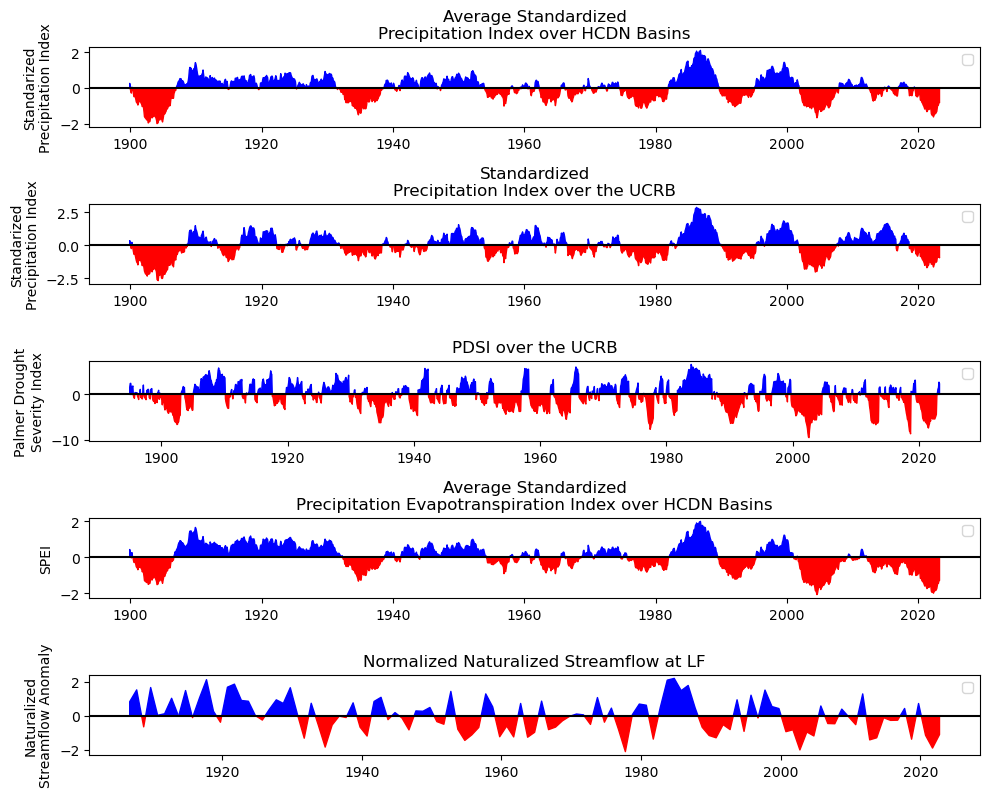

In [37]:
fig, axs = plt.subplots(nrows=5, figsize=(10,8),tight_layout=True)

# SPI over HCDN basins
ax = axs[0]


ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1),
                where=spi60_ucrb_hcdn_df.mean(axis=1)>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi60_ucrb_hcdn_df.index, 
                spi60_ucrb_hcdn_df.mean(axis=1),
                where=spi60_ucrb_hcdn_df.mean(axis=1)<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')

ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Average Standardized\nPrecipitation Index over HCDN Basins')
ax.legend()

# UCRB Basin Plot
ax = axs[1]

ax.fill_between(spi60_ucrb_rolling.index, 
                spi60_ucrb_rolling['UCRB Mean - 60 Month'],
                where=spi60_ucrb_rolling['UCRB Mean - 60 Month']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi60_ucrb_rolling.index, 
                spi60_ucrb_rolling['UCRB Mean - 60 Month'],
                where=spi60_ucrb_rolling['UCRB Mean - 60 Month']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Standarized\nPrecipitation Index')
ax.set_title('Standardized\nPrecipitation Index over the UCRB')
ax.legend()

# PDSI Plot over UCRB
ax = axs[2]
ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                alpha=0.5)

ax.fill_between(pdsi_df['anomaly'].index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spi60_ucrb_rolling.index, 
                pdsi_df['anomaly'],
                where=pdsi_df['anomaly']<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_ylabel('Palmer Drought\nSeverity Index')
ax.set_title('PDSI over the UCRB')
ax.legend()

# SPEI over HCDN basins
ax = axs[3]


ax.fill_between(spei60_ucrb_hcdn_df.index, 
                spei60_ucrb_hcdn_df.mean(axis=1),
                where=spei60_ucrb_hcdn_df.mean(axis=1)>=0,
                interpolate=True,
                color='blue')

ax.fill_between(spei60_ucrb_hcdn_df.index, 
                spei60_ucrb_hcdn_df.mean(axis=1),
                where=spei60_ucrb_hcdn_df.mean(axis=1)<0,
                interpolate=True,
                color='red')
ax.axhline(0,color='k')

ax.set_ylabel('SPEI')
ax.set_title('Average Standardized\nPrecipitation Evapotranspiration Index over HCDN Basins')
ax.legend()

# Plot Naturalized Streamflow
ax = axs[4]

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']>=norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='blue')

ax.fill_between(norm_naturalized_flow_1895['flow'].index, 
                norm_naturalized_flow_1895['flow'],
                where=norm_naturalized_flow_1895['flow']<norm_naturalized_flow_1895['flow'].mean(),
                interpolate=True,
                color='red')
ax.axhline(0,color='k')
ax.set_title('Normalized Naturalized Streamflow at LF')
ax.set_ylabel('Naturalized\nStreamflow Anomaly')
ax.legend()